In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# packing and unpacking images
def packcw(A,nr,nc):
    x = (A.T).reshape(nr*nc,1)
    return x

def unpackcw(x,nr,nc):
    A = x.reshape(nc,nr)
    return A.T

def packrw(A,nr,nc):
    x = A.reshape(nr*nc,1)
    return x

def unpackrw(x,nr,nc):
    A = x.reshape(nr,nc)
    return A

# generates a 784 element mask with columns deleted
# from the right side of the image towards the left
def generateColumnMask(delColumns):
    mask = np.ones((28, 28))
    mask[:, (28 - delColumns):] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# zero out indices of a vector for a data matrix
# for a given mask
def hideData(data, mask):
    # copy the data
    newData = data.copy()
    
    # get indices from the mask
    x_idx = np.where([mask==1])[1]
    y_idx = np.where([mask==0])[1]
    
    # apply the mask
    newData[y_idx, :] = 0
    
    return newData, data[x_idx, :], data[y_idx, :]

# get statistics for mmse
def getStatistics(data, vectorMask):
    # get mean and covariance of original data
    mean = np.mean(data, axis=1)
    cov = np.cov(data)
    
    # get indices for X, Y parts of data
    x_idx = np.where([vectorMask == 1])[1]
    y_idx = np.where([vectorMask == 0])[1]
        
    # apply masks
    u_x = mean[x_idx]
    u_y = mean[y_idx]
    cov_x = cov[x_idx]
    cov_x = cov_x[:, x_idx]
    cov_yx = cov[y_idx]
    cov_yx = cov_yx[:, x_idx]
    cov_y = cov[y_idx]
    cov_y = cov_y[:, y_idx]
    
    # return statistics
    return u_x, u_y, cov_x, cov_yx

# let's get the data for halves
def returnHalfData(ncols):
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    train_hideRight, Xtrain_hideRight, Ytrain_hideRight = hideData(train, generateColumnMask(ncols))
    test_hideRight, Xtest_hideRight, Ytest_hideRight = hideData(test, generateColumnMask(ncols))

    return train_hideRight, Xtrain_hideRight, Ytrain_hideRight, test_hideRight, Xtest_hideRight, Ytest_hideRight

# let's get the data
def returnData():
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    return train, test

----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000
----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000
---- Affine Estimator MSE ----
Train data: 0.043065
Test data: 0.046884
---- Affine Estimator MSE ----
Train data: 0.021532
Test data: 0.023442


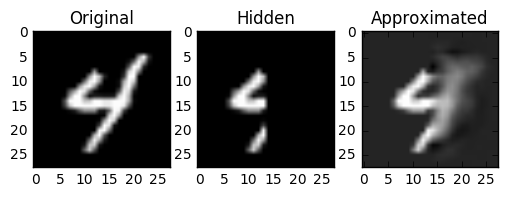

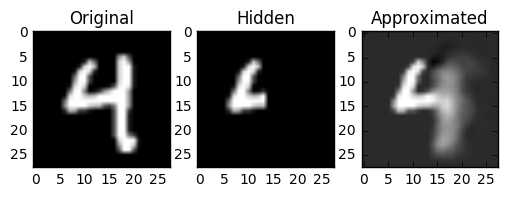

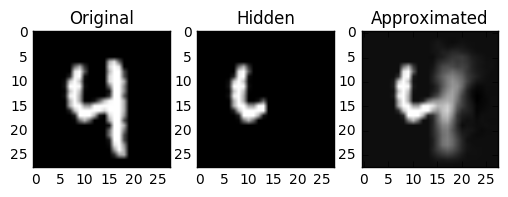

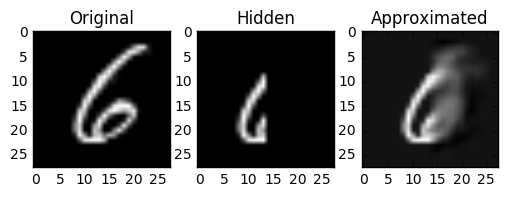

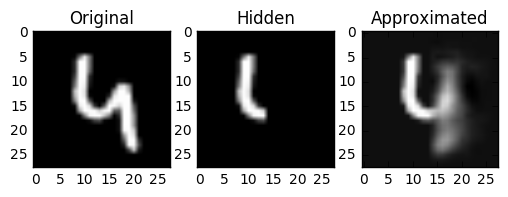

In [3]:
train, test = returnData()

train_hideRight, Xtrain_hideRight, Ytrain_hideRight, \
test_hideRight, Xtest_hideRight, Ytest_hideRight = returnHalfData(14)

u_x, u_y, cov_x, cov_yx = getStatistics(train, generateColumnMask(14))

def Wstar(cov_x, cov_yx):
    if cov_x.any():
        cov_x_inv = np.linalg.pinv(cov_x)
    else:
        cov_x_inv = cov_x
    W = np.dot(cov_yx, cov_x_inv)
    return W

def mmseEstimator(x, u_x, u_y, cov_x, cov_yx):
    W = Wstar(cov_x, cov_yx)
    dist = x - u_x.reshape((u_x.shape[0]), 1)
    return np.dot(W, dist) + u_y.reshape((u_y.shape[0]), 1)

Ytrain_hat = mmseEstimator(Xtrain_hideRight, u_x, u_y, cov_x, cov_yx)
Ytest_hat = mmseEstimator(Xtest_hideRight, u_x, u_y, cov_x, cov_yx)

maskVec = generateColumnMask(14)
x_idx = np.where([maskVec == 1])[1]
y_idx = np.where([maskVec == 0])[1]

approxImgVecs_train = np.zeros((train.shape[0], train.shape[1]))
approxImgVecs_test = np.zeros((test.shape[0], test.shape[1]))
approxImgVecs_train[x_idx, :] = Xtrain_hideRight
approxImgVecs_train[y_idx, :] = Ytrain_hat
approxImgVecs_test[x_idx, :] = Xtest_hideRight
approxImgVecs_test[y_idx, :] = Ytest_hat

for i in range(5):
    random = np.random.randint(0, 10000)    

    # original image
    original = train[:, random]
    originalImg = unpackcw(original, 28, 28)

    # hidden image
    hidden = train_hideRight[:, random]
    hiddenImg = unpackcw(hidden, 28, 28)
    
    # approximated image
    approx = approxImgVecs_train[:, random]
    approxImg = unpackcw(approx, 28, 28)
    
    # plot
    plt.figure(i); 
    plt.subplot(1, 3, 1); plt.imshow(originalImg, cmap='gray'); plt.title('Original')
    plt.subplot(1, 3, 2); plt.imshow(hiddenImg, cmap='gray'); plt.title('Hidden')
    plt.subplot(1, 3, 3); plt.imshow(approxImg, cmap='gray'); plt.title('Approximated')
    
# calculate the mse of the training and test sets using affine estimator
# this is only on the right half of every image
diff_train = Ytrain_hat - train[392:, :]
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = Ytest_hat - test[392:, :]
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Affine Estimator MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

# calculate the mse of the training and test sets using affine estimator
# this is on the whole image
diff_train = approxImgVecs_train - train
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = approxImgVecs_test - test
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Affine Estimator MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

In [3]:
# ----------------------------
#    Left to Right
# ----------------------------
predicted_train_LtoR_pre = np.load('predictedTrain_LeftToRight.npy')
predicted_test_LtoR_pre = np.load('predictedTest_LeftToRight.npy')

print '----Generated Data Loaded----'
print predicted_train_LtoR_pre.shape
print predicted_test_LtoR_pre.shape

# For right half image generation, complete the image
predicted_train_LtoR = np.zeros((train.shape[0], train.shape[1]))
predicted_test_LtoR = np.zeros((test.shape[0], test.shape[1]))

predicted_train_LtoR[x_idx] = Xtrain_hideRight
predicted_train_LtoR[y_idx] = predicted_train_LtoR_pre
predicted_test_LtoR[x_idx] = Xtest_hideRight
predicted_test_LtoR[y_idx] = predicted_test_LtoR_pre

#-------------------------
#  MSE for right half image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train[y_idx]
temp2 = test[y_idx]

diff_train = temp1 - predicted_train_LtoR_pre
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - predicted_test_LtoR_pre
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE


----Generated Data Loaded----
(392, 10000)
(392, 1000)
---- Generated Data MSE ----
Train data: 0.019066
Test data: 0.035813


In [4]:
# ----------------------------
#    Left to Original
# ----------------------------
predicted_train_LtoO = np.load('predictedTrain_LeftToOriginal.npy')
predicted_test_LtoO = np.load('predictedTest_LeftToOriginal.npy')

#-------------------------
#  MSE for whole image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train
temp2 = test

diff_train = temp1 - predicted_train_LtoO
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - predicted_test_LtoO
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

---- Generated Data MSE ----
Train data: 0.018111
Test data: 0.022777


In [5]:
# ----------------------------
#    Blanked to Original
# ----------------------------
predicted_train_BtoO = np.load('predictedTrain_BlankedToOriginal.npy')
predicted_test_BtoO = np.load('predictedTest_BlankedToOriginal.npy')

#-------------------------
#  MSE for whole image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train
temp2 = test

diff_train = temp1 - predicted_train_BtoO
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - predicted_test_BtoO
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

---- Generated Data MSE ----
Train data: 0.018628
Test data: 0.022200


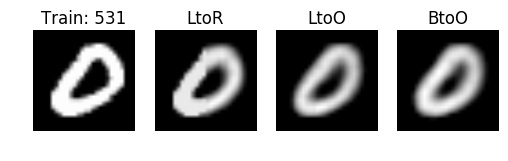

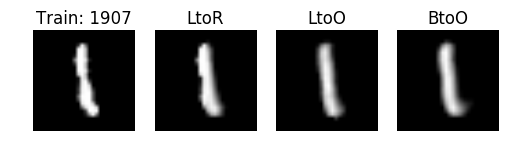

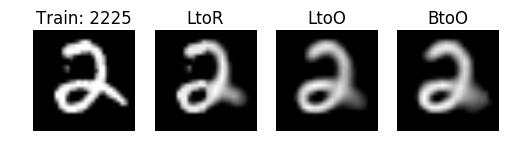

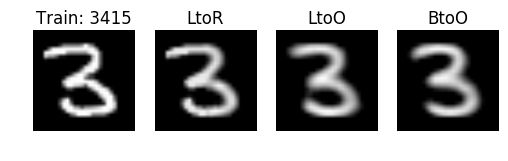

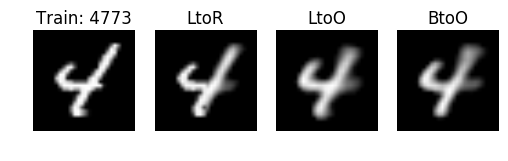

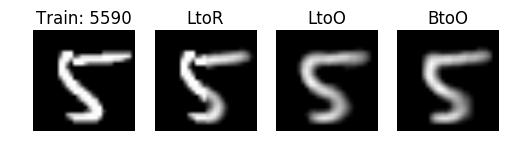

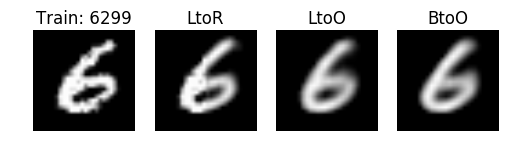

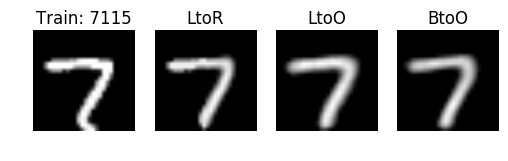

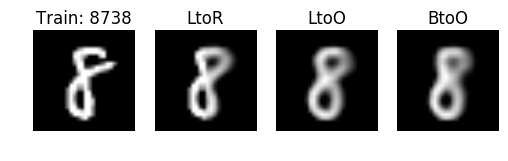

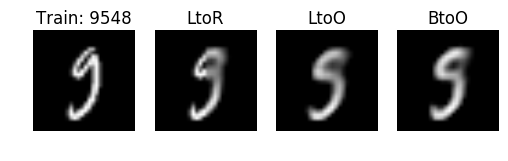

In [6]:
for i in range(10):  
    randomTrain = np.random.randint(i*1000, (i+1)*1000)
    
    origTrain = train[:, randomTrain]
    nn_train_LtoR = predicted_train_LtoR[:, randomTrain]
    nn_train_LtoO = predicted_train_LtoO[:, randomTrain]
    nn_train_BtoO = predicted_train_BtoO[:, randomTrain]

    imgOrigTrain = unpackcw(origTrain, 28, 28)
    imgTrain_LtoR = unpackcw(nn_train_LtoR, 28, 28)
    imgTrain_LtoO = unpackcw(nn_train_LtoO, 28, 28)
    imgTrain_BtoO = unpackcw(nn_train_BtoO, 28, 28)
    
    plt.figure(i);
    plt.subplot(1, 4, 1); plt.imshow(imgOrigTrain, cmap='gray'); plt.title('Train: %d' %randomTrain); plt.axis('off')
    plt.subplot(1, 4, 2); plt.imshow(imgTrain_LtoR, cmap='gray'); plt.title('LtoR'); plt.axis('off')
    plt.subplot(1, 4, 3); plt.imshow(imgTrain_LtoO, cmap='gray'); plt.title('LtoO'); plt.axis('off')
    plt.subplot(1, 4, 4); plt.imshow(imgTrain_BtoO, cmap='gray'); plt.title('BtoO'); plt.axis('off')

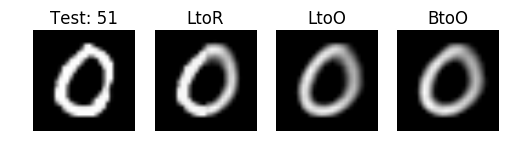

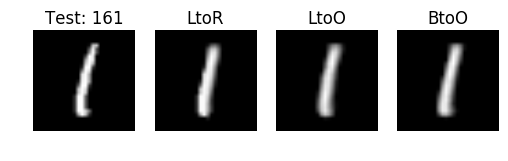

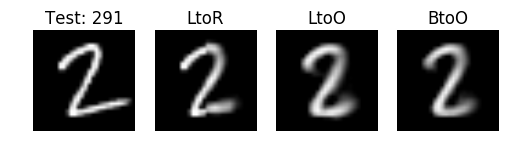

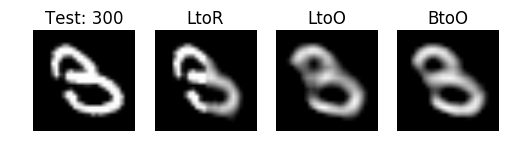

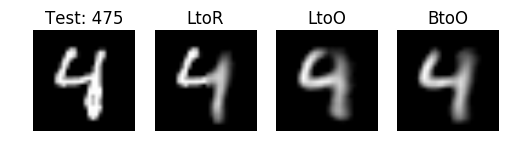

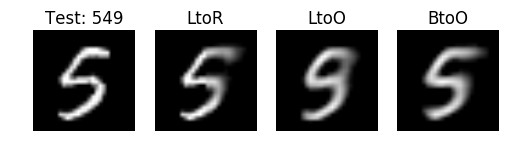

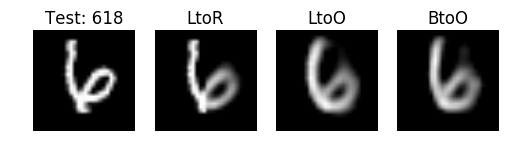

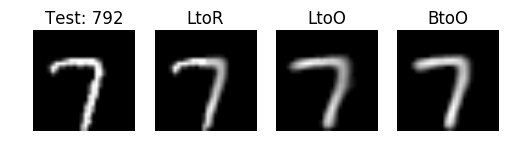

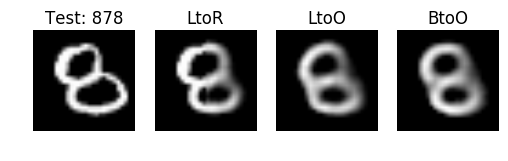

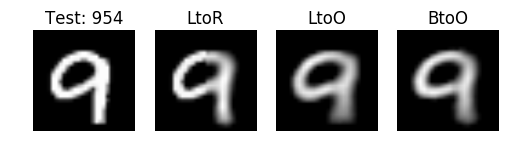

In [7]:
for i in range(10):  
    randomTest = np.random.randint(i*100, (i+1)*100)
    
    origTest = test[:, randomTest]
    nn_test_LtoR = predicted_test_LtoR[:, randomTest]
    nn_test_LtoO = predicted_test_LtoO[:, randomTest]
    nn_test_BtoO = predicted_test_BtoO[:, randomTest]

    imgOrigTest = unpackcw(origTest, 28, 28)
    imgTest_LtoR = unpackcw(nn_test_LtoR, 28, 28)
    imgTest_LtoO = unpackcw(nn_test_LtoO, 28, 28)
    imgTest_BtoO = unpackcw(nn_test_BtoO, 28, 28)

    plt.figure(i); 
    plt.subplot(1, 4, 1); plt.imshow(imgOrigTest, cmap='gray'); plt.title('Test: %d' %randomTest); plt.axis('off')
    plt.subplot(1, 4, 2); plt.imshow(imgTest_LtoR, cmap='gray'); plt.title('LtoR'); plt.axis('off')
    plt.subplot(1, 4, 3); plt.imshow(imgTest_LtoO, cmap='gray'); plt.title('LtoO'); plt.axis('off')
    plt.subplot(1, 4, 4); plt.imshow(imgTest_BtoO, cmap='gray'); plt.title('BtoO'); plt.axis('off')

In [4]:
# ----------------------------
#    Other testing - Various MSE metrics (just generated or whole image lolz)
# ----------------------------
predicted_train = np.load('predictedTrain.npy')
predicted_test = np.load('predictedTest.npy')

#-------------------------
#  MSE for whole image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train
temp2 = test

diff_train = temp1 - predicted_train
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - predicted_test
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

#------------------------------------------
#  MSE for unknown portion of image
#------------------------------------------
maskVec = generateColumnMask(14)
x_idx = np.where([maskVec == 1])[1]
y_idx = np.where([maskVec == 0])[1]

hidden_predictedTrain, X_predictedTrain, Y_predictedTrain = hideData(predicted_train, maskVec)
hidden_predictedTest, X_predictedTest, Y_predictedTest = hideData(predicted_test, maskVec)

temp1 = train[y_idx]
temp2 = test[y_idx]

diff_train = temp1 - Y_predictedTrain
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - Y_predictedTest
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE (Middle Image - Y) ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

temp1 = train[x_idx]
temp2 = test[x_idx]

diff_train = temp1 - X_predictedTrain
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - X_predictedTest
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)
testMSE2 = np.mean(np.multiply(diff_test, diff_test))
print '---- Generated Data MSE (Outside Image - X) ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE
print '---- Either way of defining MSE works ----'
print testMSE
print testMSE2

---- Generated Data MSE ----
Train data: 0.014384
Test data: 0.015986
---- Generated Data MSE (Right Image - Y) ----
Train data: 0.015625
Test data: 0.017420
---- Generated Data MSE (Left Image - X) ----
Train data: 0.013142
Test data: 0.014552
---- Either way of defining MSE works ----
0.0145521488148
0.0145521488148


In [45]:
testSplit_X = np.zeros((10, Xtest_hideRight.shape[0], Xtest_hideRight.shape[1]/10))
testSplit_Y = np.zeros((10, Ytest_hideRight.shape[0], Ytest_hideRight.shape[1]/10))

testSplit_X_hat = np.zeros((10, X_predictedTest.shape[0], X_predictedTest.shape[1]/10))
testSplit_Y_hat = np.zeros((10, Y_predictedTest.shape[0], Y_predictedTest.shape[1]/10))

for i in range(10):
  for j in range(10):
    testSplit_X[i, :, j*10:(j+1)*10] = Xtest_hideRight[:, j*100+i*10:j*100+(i+1)*10]
    testSplit_Y[i, :, j*10:(j+1)*10] = Ytest_hideRight[:, j*100+i*10:j*100+(i+1)*10]
    testSplit_X_hat[i, :, j*10:(j+1)*10] = X_predictedTest[:, j*100+i*10:j*100+(i+1)*10]
    testSplit_Y_hat[i, :, j*10:(j+1)*10] = Y_predictedTest[:, j*100+i*10:j*100+(i+1)*10]


In [46]:
temp = np.zeros(10)
for i in range(10):
    diff_Split = testSplit_Y_hat[i] - testSplit_Y[i]
    temp[i] = np.mean(np.multiply(diff_Split, diff_Split))
    
print temp
print np.mean(temp)
print np.std(temp)

[ 0.03736349  0.03796672  0.03850286  0.04074313  0.03724218  0.03732315
  0.03781038  0.03888634  0.03865147  0.03643159]
0.0380921311849
0.00113301725612
